References:
- [State Space Models and the Kalman Filter](https://eml.berkeley.edu/~rothenbe/Fall2007/kalman.pdf)
- [Kalman filter and smoother](https://jwmi.github.io/ASM/6-KalmanFilter.pdf)
- [Optimal Smoothing](https://users.aalto.fi/~ssarkka/course_k2011/pdf/handout7.pdf)
- [Bayesian state-space models with PyMC3](https://github.com/luisroque/bayesian_time_series/blob/main/5%20Levels%20of%20Difficulty%20-%20Bayesian%20Gaussian%20Random%20Walk%20with%20PyMC3%20and%20Theano.ipynb)
- [AR models with PYMC3](https://www.pymc.io/projects/examples/en/latest/time_series/AR.html)
- [AR models with multiple inputs](https://discourse.pymc.io/t/multiple-time-series/5868/2)

In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

import pymc3 as pm
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

from density_decoding.utils.utils import set_seed

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 30
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

In [3]:
dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
]

test_pid = pids[0]
print(test_pid)

saved_y_obs, saved_y_hat = {}, {}
for brain_region in ["all", "po", "lp", "dg", "ca1", "vis"]:
    
    y_obs, y_hat, k_idx = [], [], []

    for i in range(5):
        y_obs.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        y_hat.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_pred"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        k_idx.append(
            np.load(
                dir_path/test_pid/"choice"/brain_region/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )

    k_idx = np.concatenate(k_idx)
    y_obs = np.concatenate(y_obs)[np.argsort(k_idx)]
    y_hat = np.concatenate(y_hat)[np.argsort(k_idx)]
    
    saved_y_obs.update({brain_region: y_obs})
    saved_y_hat.update({brain_region: y_hat})

dab512bd-a02d-4c1f-8dbc-9155a163efc0


Kalman Filter and Smoothing

In [85]:
saved_smoothed_y, saved_metrics = {}, {}

brain_region = "ca1"

noise = 1e-3
Q = 1e-3

fk = KalmanFilter(dim_x=2, dim_z=1)

fk.x = np.array([0., 1.])      # state (x and dx)

fk.F = np.array([[1., 1.],
                 [0., 1.]])    # state transition matrix

fk.H = np.array([[1., 0.]])    # measurement function
fk.P *= 10.                    # covariance matrix
fk.R = noise                   # state uncertainty
fk.Q = Q_discrete_white_noise(dim=2, dt=1., var=Q)  # process uncertainty

# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = fk.batch_filter(saved_y_hat[brain_region])
M, P, C, _ = fk.rts_smoother(mu, cov)

saved_smoothed_y.update({brain_region: M[:,0]})
    
metrics = {}
metrics.update({
    "r2": {
        "smooth": r2_score(y_obs, M[:, 0]),
        "orig": r2_score(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "mse": {
        "smooth": mean_squared_error(y_obs, M[:, 0]),
        "orig": mean_squared_error(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "corr": {
      "smooth": pearsonr(y_obs, M[:, 0])[0],
      "orig": pearsonr(y_obs, saved_y_hat[brain_region])[0]
    },
})
saved_metrics.update({brain_region: metrics})

In [86]:
saved_metrics

{'ca1': {'r2': {'smooth': 0.13960680665475467, 'orig': -0.09028564965119501},
  'mse': {'smooth': 0.027984633829631636, 'orig': 0.035461978210870916},
  'corr': {'smooth': 0.3751553878109337, 'orig': 0.21929542664167276}}}

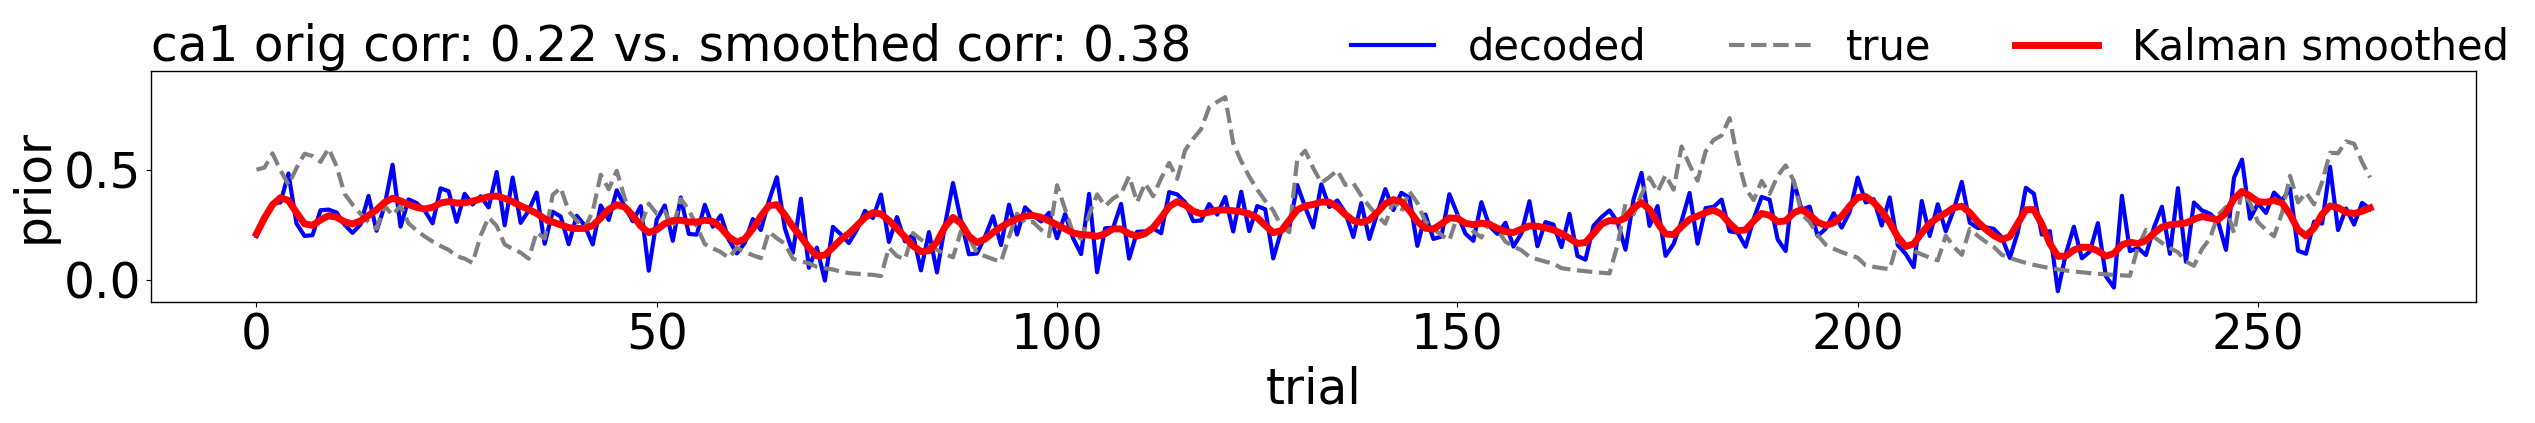

In [87]:
plt.figure(figsize=(30, 3))
plt.plot(saved_y_hat[brain_region], c="b", ls='-', linewidth=3, label="decoded")
plt.plot(saved_y_obs[brain_region], c="gray", ls='--', linewidth=3, label="true")
plt.plot(saved_smoothed_y[brain_region], c='r', linewidth=5, label='Kalman smoothed')
plt.xlabel("trial")
plt.ylabel("prior")
plt.title(f"{brain_region} orig corr: {saved_metrics[brain_region]['corr']['orig']:.2f} vs. smoothed corr: {saved_metrics[brain_region]['corr']['smooth']:.2f}", loc='left')
plt.ylim(-.1, 0.95)
plt.legend(ncols=3, loc='center left', bbox_to_anchor=(0.5, 1.1), fontsize=30, frameon=False)
plt.show()

Linear Gaussian state space model: $y_t$ is decoded prior and $x_t$ is true prior.

1. Dynamic model AR(1): 
    
$$x_t = \rho x_{t-1} + \xi_t, \quad \rho \sim \mathcal{N}(\mu_\rho, \sigma_\rho^2), \quad \xi_t \sim \mathcal{N}(0, \sigma_\xi^2)$$
        
2. Observation model:

$$y_t = \alpha + \beta x_{t-1} + \epsilon_t, \quad \alpha  \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha^2), \quad \beta  \sim \mathcal{N}(\mu_\beta, \sigma_\beta^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$$

In [88]:
ys, ds = [], []
for _, pid in enumerate(pids):
    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"prior"/brain_region/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        d.append(
            np.load(
                dir_path/pid/"prior"/brain_region/"y_pred"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"prior"/brain_region/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx)]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_130570/3878951434.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_130570/3878951434.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [89]:
test_pid_idx = 0
pid = pids[test_pid_idx]
print(pid)
print(brain_region)

train_pid_idxs = np.delete(np.arange(len(pids)), test_pid_idx)
train_ys, test_ys = ys[train_pid_idxs], ys[test_pid_idx]
train_ds, test_ds = ds[train_pid_idxs], ds[test_pid_idx]

dab512bd-a02d-4c1f-8dbc-9155a163efc0
ca1


In [90]:
min_seq_len = np.min([len(ys) for ys in train_ys])
train_ys = np.array([ys[:min_seq_len] for ys in train_ys]).T.squeeze()
train_ds = np.array([ds[:min_seq_len] for ds in train_ds]).T.squeeze()

In [95]:
seq_len = len(saved_y_hat[brain_region])

with pm.Model() as vanilla_ssm:
    
    # priors
    rho = pm.Normal("rho", mu=0, sigma=1, shape=1)
    sigma_xi = pm.HalfNormal("xi", sigma=1, shape=1)
    
    # low snr
    alpha = pm.Normal("alpha", mu=0.5, sigma=1, shape=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=1)
    # high snr
    # alpha = pm.Normal("alpha", mu=0, sigma=1, shape=1)
    # beta = pm.Normal("beta", mu=1, sigma=1, shape=1)
    
    sigma_eps = pm.HalfNormal("eps", sigma=1, shape=1)
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/sigma_xi, observed=train_ys)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=sigma_eps, 
                  observed=train_ds)
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      # init='advi+adapt_diag',
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state", "beta", "alpha", "rho", "eps", "xi"], random_seed=seed
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, xi, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [98]:
alpha = ppc["alpha"].mean(0)
beta = ppc["beta"].mean(0)
rho = ppc["rho"].mean(0)
sigma_xi = ppc["xi"].mean(0)
sigma_eps = ppc["eps"].mean(0)
print([alpha, beta, rho])

[array([0.47038092]), array([0.1564207]), array([0.97454408])]


In [99]:
seq_len = len(test_ds)

with pm.Model() as vanilla_ssm:
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/sigma_xi, shape=seq_len)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=sigma_eps, 
                  observed=test_ds.squeeze())
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      # init='advi+adapt_diag',
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state"], random_seed=seed
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [100]:
saved_smoothed_y = {}
saved_smoothed_y.update({brain_region: ppc["obs"].mean(0)})

In [101]:
metrics = {}
metrics.update({
    "r2": {
        "smooth": r2_score(y_obs, saved_smoothed_y[brain_region]),
        "orig": r2_score(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "mse": {
        "smooth": mean_squared_error(y_obs, saved_smoothed_y[brain_region]),
        "orig": mean_squared_error(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "corr": {
      "smooth": pearsonr(y_obs, saved_smoothed_y[brain_region])[0],
      "orig": pearsonr(y_obs, saved_y_hat[brain_region])[0]
    },
})
saved_metrics.update({brain_region: metrics})

In [102]:
saved_metrics

{'ca1': {'r2': {'smooth': 0.1567013885282641, 'orig': -0.09028564965119501},
  'mse': {'smooth': 0.027428625695326392, 'orig': 0.035461978210870916},
  'corr': {'smooth': 0.5336450333047583, 'orig': 0.21929542664167276}}}

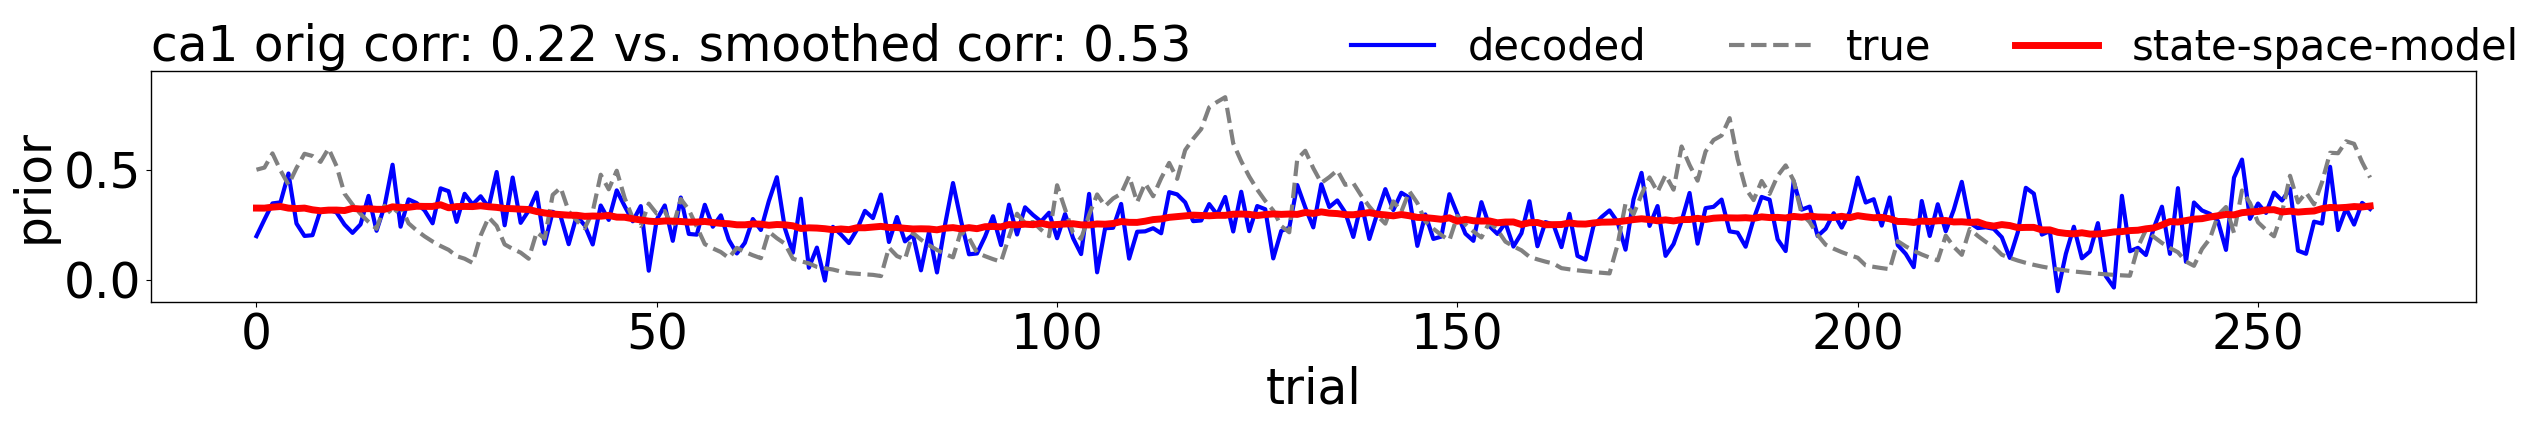

In [103]:
plt.figure(figsize=(30, 3))
plt.plot(saved_y_hat[brain_region], c="b", ls='-', linewidth=3, label="decoded")
plt.plot(saved_y_obs[brain_region], c="gray", ls='--', linewidth=3, label="true")
plt.plot(saved_smoothed_y[brain_region], c='r', linewidth=5, label='state-space-model')
plt.xlabel("trial")
plt.ylabel("prior")
plt.title(f"{brain_region} orig corr: {saved_metrics[brain_region]['corr']['orig']:.2f} vs. smoothed corr: {saved_metrics[brain_region]['corr']['smooth']:.2f}", loc='left')
plt.ylim(-.1, 0.95)
plt.legend(ncols=3, loc='center left', bbox_to_anchor=(0.5, 1.1), fontsize=30, frameon=False)
plt.show()